In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N   T  MSE  STD
0  36   1  0.0  0.0
1  34  15  0.0  0.0
2  65  14  0.0  0.0
3   5   4  0.0  0.0
4  63  20  0.0  0.0
{'Y': 'Fch4', 'reps': 9, 'T_Max': 24, 'epochs': 10, 'proc': 3, 'Searches': 2, 'N_Max': 100}


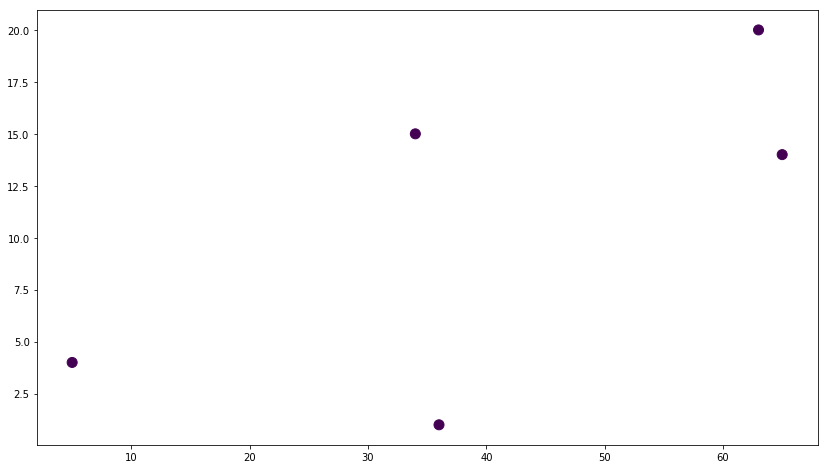

In [2]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 12
            samp_size = 20
            Searches = 10
        else:
            epochs = 10
            reps = 9
            N_Max = 100
            T_Max = 24
            samp_size = 5
            Searches = 2
        N = np.array(np.random.rand(samp_size)*(N_Max-1)+1,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=3
        self.params['Searches']=Searches

rpms = Params('Test','Fch4')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [3]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [4]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
#     epochs = 100
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    while killscore < killmax and e < epochs:
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE)
           

In [16]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i=i,Memory=Memory))


Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC',' Active Layer','24H Rain','Wtr Tbl Trnd','ET']


Model = ['Water Table']

Model = [' Active Layer','H']

Time = time.time()

Path = 'FilteredData2018-03-30.csv'#'FI_Data.csv' 
def RunReps(Model,Runs,params,pool = None):
    RST = ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,mse in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            mse = TTV_Split(i,Memory,X,y,params)
            MSE.append(mse)
    MSE = np.asanyarray(MSE)
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehd Run ',str(i))
    print(' Stats: ')
    print(Runs.iloc[i])

print(Runs)
  
print(time.time()-Time)
        

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  0
 Stats: 
MSE    0.975554
N      5.000000
STD    0.204676
T      4.000000
Name: 0, dtype: float64
Finisehd Run  1
 Stats: 
MSE     0.906096
N      34.000000
STD     0.141653
T      15.000000
Name: 1, dtype: float64
Finisehd Run  2
 Stats: 
MSE     0.937745
N      36.000000
STD     0.114819
T       1.000000
Name: 2, dtype: float64
Finisehd Run  3
 Stats: 
MSE     0.863455
N      62.000000
STD     0.156208
T      15.000000
Name: 3, dtype: float64
Finisehd Run  4
 Stats: 
MSE     0.934392
N      63.000000
STD     0.144819
T      20.000000
Name: 4, dtype: float64
Finisehd Run  5
 Stats: 
MSE     0.886801
N      65.000000
STD     0.113984
T      14.000000
Name: 5, dtype: float64
Finisehd Run  6
 Stats: 
MSE     0.831038
N      66.000000
STD     0.142284
T      11.000000
Name: 6, dtype: float64
Finisehd Run  7
 Stats: 
MSE     1.000991
N      67.000000
STD     0.133788
T      16.000000
Name: 7, dtype: float64
        MSE   N       STD   T
0  0.975554   5  0.204676   4
1  0.906

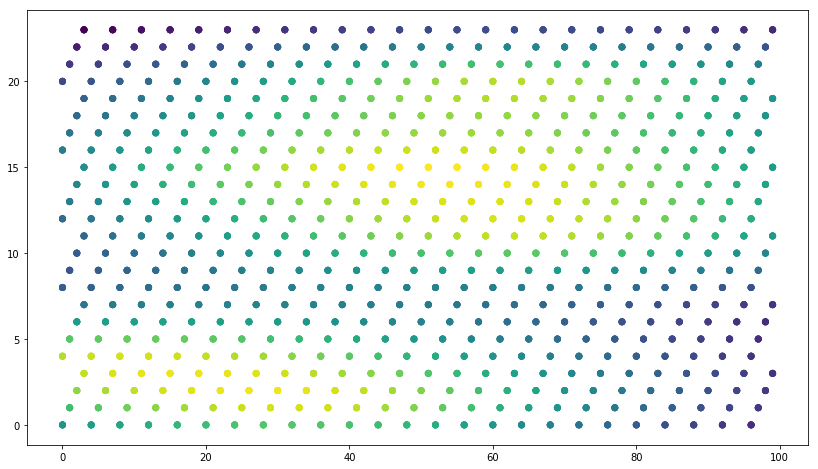

In [14]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=False)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)


N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T
y_pred,sigma = gp.predict(X,return_std=True)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.legend()
Runs2 = Runs.copy()

In [15]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

[ 67.12954408  15.89727685]
67 16


ValueError: Pool not running

In [ ]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

CH4 Results: 
    
      MSE     N     STD     T
12  0.233444  23  0.031446  0

CH4 Results:

         MSE   N      STD  T
10  0.061422  82  0.01039  2